In [1]:
import torch
import torch.utils.data
import torch.nn
import os
import PIL.Image
import json
import tqdm
import trt_pose
import trt_pose.plugins
import glob
import torchvision.transforms.functional as FT
import numpy as np
from trt_pose.parse_objects import ParseObjects
import pycocotools
import pycocotools.coco
import pycocotools.cocoeval
import torchvision
import shutil

        
def coco_category_to_topology(coco_category):
    """Gets topology tensor from a COCO category
    """
    skeleton = coco_category['skeleton']
    K = len(skeleton)
    topology = torch.zeros((K, 4)).int()
    for k in range(K):
        topology[k][0] = 2 * k
        topology[k][1] = 2 * k + 1
        topology[k][2] = skeleton[k][0] - 1
        topology[k][3] = skeleton[k][1] - 1
    return topology


def coco_category_to_parts(coco_category):
    """Gets list of parts name from a COCO category
    """
    return coco_category['keypoints']


def coco_annotations_to_tensors(coco_annotations,
                                image_shape,
                                parts,
                                topology,
                                max_count=100):
    """Gets tensors corresponding to peak counts, peak coordinates, and peak to peak connections
    """
    annotations = coco_annotations
    C = len(parts)
    K = topology.shape[0]
    M = max_count
    IH = image_shape[0]
    IW = image_shape[1]
    counts = torch.zeros((C)).int()
    peaks = torch.zeros((C, M, 2)).float()
    visibles = torch.zeros((len(annotations), C)).int()
    connections = -torch.ones((K, 2, M)).int()

    for ann_idx, ann in enumerate(annotations):

        kps = ann['keypoints']

        # add visible peaks
        for c in range(C):

            x = kps[c * 3]
            y = kps[c * 3 + 1]
            visible = kps[c * 3 + 2]

            if visible:
                peaks[c][counts[c]][0] = (float(y) + 0.5) / (IH + 1.0)
                peaks[c][counts[c]][1] = (float(x) + 0.5) / (IW + 1.0)
                counts[c] = counts[c] + 1
                visibles[ann_idx][c] = 1

        for k in range(K):
            c_a = topology[k][2]
            c_b = topology[k][3]
            if visibles[ann_idx][c_a] and visibles[ann_idx][c_b]:
                connections[k][0][counts[c_a] - 1] = counts[c_b] - 1
                connections[k][1][counts[c_b] - 1] = counts[c_a] - 1

    return counts, peaks, connections


def coco_annotations_to_mask_bbox(coco_annotations, image_shape):
    mask = np.ones(image_shape, dtype=np.uint8)
    for ann in coco_annotations:
        if 'num_keypoints' not in ann or ann['num_keypoints'] == 0:
            bbox = ann['bbox']
            x0 = round(bbox[0])
            y0 = round(bbox[1])
            x1 = round(x0 + bbox[2])
            y1 = round(y0 + bbox[3])
            mask[y0:y1, x0:x1] = 0
    return mask
            

def convert_dir_to_bmp(output_dir, input_dir):
    files = glob.glob(os.path.join(input_dir, '*.jpg'))
    for f in files:
        new_path = os.path.join(
            output_dir,
            os.path.splitext(os.path.basename(f))[0] + '.bmp')
        img = PIL.Image.open(f)
        img.save(new_path)

        
def get_quad(angle, translation, scale, aspect_ratio=1.0):
    if aspect_ratio > 1.0:
        # width > height =>
        # increase height region
        quad = np.array([
            [0.0, 0.5 - 0.5 * aspect_ratio],
            [0.0, 0.5 + 0.5 * aspect_ratio],
            [1.0, 0.5 + 0.5 * aspect_ratio],
            [1.0, 0.5 - 0.5 * aspect_ratio],
            
        ])
    elif aspect_ratio < 1.0:
        # width < height
        quad = np.array([
            [0.5 - 0.5 / aspect_ratio, 0.0],
            [0.5 - 0.5 / aspect_ratio, 1.0],
            [0.5 + 0.5 / aspect_ratio, 1.0],
            [0.5 + 0.5 / aspect_ratio, 0.0],
            
        ])
    else:
        quad = np.array([
            [0.0, 0.0],
            [0.0, 1.0],
            [1.0, 1.0],
            [1.0, 0.0],
        ])
        
    quad -= 0.5

    R = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    quad = np.dot(quad, R)

    quad -= np.array(translation)
    quad /= scale
    quad += 0.5
    
    return quad


def transform_image(image, size, quad):
    new_quad = np.zeros_like(quad)
    new_quad[:, 0] = quad[:, 0] * image.size[0]
    new_quad[:, 1] = quad[:, 1] * image.size[1]
    
    new_quad = (new_quad[0][0], new_quad[0][1],
            new_quad[1][0], new_quad[1][1],
            new_quad[2][0], new_quad[2][1],
            new_quad[3][0], new_quad[3][1])
    
    return image.transform(size, PIL.Image.QUAD, new_quad)


def transform_points_xy(points, quad):
    p00 = quad[0]
    p01 = quad[1] - p00
    p10 = quad[3] - p00
    p01 /= np.sum(p01**2)
    p10 /= np.sum(p10**2)
    
    A = np.array([
        p10,
        p01,
    ]).transpose()
    
    return np.dot(points - p00, A)


def transform_peaks(counts, peaks, quad):
    newpeaks = peaks.clone().numpy()
    C = counts.shape[0]
    for c in range(C):
        count = int(counts[c])
        newpeaks[c][0:count] = transform_points_xy(newpeaks[c][0:count][:, ::-1], quad)[:, ::-1]
    return torch.from_numpy(newpeaks)


class CocoDataset(torch.utils.data.Dataset):
    def __init__(self,
                 images_dir,
                 annotations_file,
                 category_name,
                 image_shape,
                 target_shape,
                 is_bmp=False,
                 stdev=0.02,
                 use_crowd=False,
                 min_area=0.0,
                 max_area=1.0,
                 max_part_count=100,
                 random_angle=(0.0, 0.0),
                 random_scale=(1.0, 1.0),
                 random_translate=(0.0, 0.0),
                 transforms=None,
                 keep_aspect_ratio=False):

        self.keep_aspect_ratio = keep_aspect_ratio
        self.transforms=transforms
        self.is_bmp = is_bmp
        self.images_dir = images_dir
        self.image_shape = image_shape
        self.target_shape = target_shape
        self.stdev = stdev
        self.random_angle = random_angle
        self.random_scale = random_scale
        self.random_translate = random_translate
        
        tensor_cache_file = annotations_file + '.cache'
        
        if tensor_cache_file is not None and os.path.exists(tensor_cache_file):
            print('Cachefile found.  Loading from cache file...')
            cache = torch.load(tensor_cache_file)
            self.counts = cache['counts']
            self.peaks = cache['peaks']
            self.connections = cache['connections']
            self.topology = cache['topology']
            self.parts = cache['parts']
            self.filenames = cache['filenames']
            self.samples = cache['samples']
            return
            
        with open(annotations_file, 'r') as f:
            data = json.load(f)

        cat = [c for c in data['categories'] if c['name'] == category_name][0]
        cat_id = cat['id']

        img_map = {}
        for img in data['images']:
            img_map[img['id']] = img

        samples = {}
        for ann in data['annotations']:

            # filter by category
            if ann['category_id'] != cat_id:
                continue

            # filter by crowd
            if not use_crowd and ann['iscrowd']:
                continue

            img_id = ann['image_id']
            img = img_map[img_id]
            height = img['height']
            width = img['width']
            area = ann['area']

            # filter by object area
            normalized_area = float(area) / float(height * width)
            if normalized_area < min_area or normalized_area > max_area:
                continue

            # add metadata
            if img_id not in samples:
                sample = {}
                sample['img'] = img
                sample['anns'] = [ann]
                samples[img_id] = sample
            else:
                samples[img_id]['anns'] += [ann]
                
        # generate tensors
        self.topology = coco_category_to_topology(cat)
        self.parts = coco_category_to_parts(cat)

        N = len(samples)
        C = len(self.parts)
        K = self.topology.shape[0]
        M = max_part_count

        print('Generating intermediate tensors...')
        self.counts = torch.zeros((N, C), dtype=torch.int32)
        self.peaks = torch.zeros((N, C, M, 2), dtype=torch.float32)
        self.connections = torch.zeros((N, K, 2, M), dtype=torch.int32)
        self.filenames = []
        self.samples = []
        
        for i, sample in tqdm.tqdm(enumerate(samples.values())):
            filename = sample['img']['file_name']
            self.filenames.append(filename)
            image_shape = (sample['img']['height'], sample['img']['width'])
            counts_i, peaks_i, connections_i = coco_annotations_to_tensors(
                sample['anns'], image_shape, self.parts, self.topology)
            self.counts[i] = counts_i
            self.peaks[i] = peaks_i
            self.connections[i] = connections_i
            self.samples += [sample]

        # if tensor_cache_file is not None:
        #     print('Saving to intermediate tensors to cache file...')
        #     torch.save({
        #         'counts': self.counts,
        #         'peaks': self.peaks,
        #         'connections': self.connections,
        #         'topology': self.topology,
        #         'parts': self.parts,
        #         'filenames': self.filenames,
        #         'samples': self.samples
        #     }, tensor_cache_file)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        if self.is_bmp:
            filename = os.path.splitext(self.filenames[idx])[0] + '.bmp'
        else:
            filename = os.path.splitext(self.filenames[idx])[0] + '.jpg'

        image = PIL.Image.open(os.path.join(self.images_dir, filename))
        
        im = self.samples[idx]['img']
        
        mask = coco_annotations_to_mask_bbox(self.samples[idx]['anns'], (im['height'], im['width']))
        mask = PIL.Image.fromarray(mask)
        
        counts = self.counts[idx]
        peaks = self.peaks[idx]
        
        # affine transformation
        shiftx = float(torch.rand(1)) * (self.random_translate[1] - self.random_translate[0]) + self.random_translate[0]
        shifty = float(torch.rand(1)) * (self.random_translate[1] - self.random_translate[0]) + self.random_translate[0]
        scale = float(torch.rand(1)) * (self.random_scale[1] - self.random_scale[0]) + self.random_scale[0]
        angle = float(torch.rand(1)) * (self.random_angle[1] - self.random_angle[0]) + self.random_angle[0]
        
        if self.keep_aspect_ratio:
            ar = float(image.width) / float(image.height)
            quad = get_quad(angle, (shiftx, shifty), scale, aspect_ratio=ar)
        else:
            quad = get_quad(angle, (shiftx, shifty), scale, aspect_ratio=1.0)
        
        image = transform_image(image, (self.image_shape[1], self.image_shape[0]), quad)
        mask = transform_image(mask, (self.target_shape[1], self.target_shape[0]), quad)
        peaks = transform_peaks(counts, peaks, quad)
        
        counts = counts[None, ...]
        peaks = peaks[None, ...]

        stdev = float(self.stdev * self.target_shape[0])

        cmap = trt_pose.plugins.generate_cmap(counts, peaks,
            self.target_shape[0], self.target_shape[1], stdev, int(stdev * 5))

        paf = trt_pose.plugins.generate_paf(
            self.connections[idx][None, ...], self.topology,
            counts, peaks,
            self.target_shape[0], self.target_shape[1], stdev)

        image = image.convert('RGB')
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, cmap[0], paf[0], torch.from_numpy(np.array(mask))[None, ...]

    def get_part_type_counts(self):
        return torch.sum(self.counts, dim=0)
    
    def get_paf_type_counts(self):
        c = torch.sum(self.connections[:, :, 0, :] >= 0, dim=-1) # sum over parts
        c = torch.sum(c, dim=0) # sum over batch
        return c
    
    
class CocoHumanPoseEval(object):
    
    def __init__(self, images_dir, annotation_file, image_shape, keep_aspect_ratio=False):
        
        self.images_dir = images_dir
        self.annotation_file = annotation_file
        self.image_shape = tuple(image_shape)
        self.keep_aspect_ratio = keep_aspect_ratio
        
        self.cocoGt = pycocotools.coco.COCO('annotations/person_keypoints_val2017.json')
        self.catIds = self.cocoGt.getCatIds('person')
        self.imgIds = self.cocoGt.getImgIds(catIds=self.catIds)
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
    def evaluate(self, model, topology):
        self.parse_objects = ParseObjects(topology, cmap_threshold=0.1, link_threshold=0.1, cmap_window=5, line_integral_samples=7, max_num_parts=100, max_num_objects=100)
        
        results = []

        for n, imgId in enumerate(self.imgIds[1:]):

            # read image
            img = self.cocoGt.imgs[imgId]
            img_path = os.path.join(self.images_dir, img['file_name'])

            image = PIL.Image.open(img_path).convert('RGB')#.resize(IMAGE_SHAPE)
            
            if self.keep_aspect_ratio:
                ar = float(image.width) / float(image.height)
            else:
                ar = 1.0
                
            quad = get_quad(0.0, (0, 0), 1.0, aspect_ratio=ar)
            image = transform_image(image, self.image_shape, quad)

            data = self.transform(image).cuda()[None, ...]

            cmap, paf = model(data)
            cmap, paf = cmap.cpu(), paf.cpu()

        #     object_counts, objects, peaks, int_peaks = postprocess(cmap, paf, cmap_threshold=0.05, link_threshold=0.01, window=5)
        #     object_counts, objects, peaks = int(object_counts[0]), objects[0], peaks[0]

            object_counts, objects, peaks = self.parse_objects(cmap, paf)
            object_counts, objects, peaks = int(object_counts[0]), objects[0], peaks[0]

            for i in range(object_counts):
                object = objects[i]
                score = 0.0
                kps = [0]*(17*3)
                x_mean = 0
                y_mean = 0
                cnt = 0
                for j in range(17):
                    k = object[j]
                    if k >= 0:
                        peak = peaks[j][k]
                        if ar > 1.0: # w > h w/h
                            x = peak[1]
                            y = (peak[0] - 0.5) * ar + 0.5
                        else:
                            x = (peak[1] - 0.5) / ar + 0.5
                            y = peak[0]

                        x = round(float(img['width'] * x))
                        y = round(float(img['height'] * y))

                        score += 1.0
                        kps[j * 3 + 0] = x
                        kps[j * 3 + 1] = y
                        kps[j * 3 + 2] = 2
                        x_mean += x
                        y_mean += y
                        cnt += 1

                ann = {
                    'image_id': imgId,
                    'category_id': 1,
                    'keypoints': kps,
                    'score': score / 17.0
                }
                results.append(ann)
            if n % 100 == 0:
                print('%d / %d' % (n, len(self.imgIds)))


        if len(results) == 0:
            return
        
        with open('trt_pose_results.json', 'w') as f:
            json.dump(results, f)
            
        cocoDt = self.cocoGt.loadRes('trt_pose_results.json')
        cocoEval = pycocotools.cocoeval.COCOeval(self.cocoGt, cocoDt, 'keypoints')
        cocoEval.params.imgIds = self.imgIds
        cocoEval.params.catIds = [1]
        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

In [2]:
import argparse
import subprocess
import torch
import torchvision
import os
import torch.optim
import tqdm
import apex.amp as amp
import time
import json
import pprint
import torch.nn.functional as F
import cv2
#from trt_pose.coco import CocoDataset, CocoHumanPoseEval
from trt_pose.models import MODELS
import random
from PIL import Image


In [3]:
OPTIMIZERS = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam
}

EPS = 1e-6

def set_lr(optimizer, lr):
    for p in optimizer.param_groups:
        p['lr'] = lr
        
        
def save_checkpoint(model, directory, epoch):
    if not os.path.exists(directory):
        os.mkdir(directory)
    filename = os.path.join(directory, 'epoch_%d.pth' % epoch)
    print('Saving checkpoint to %s' % filename)
    torch.save(model.state_dict(), filename)

    
def write_log_entry(logfile, epoch, train_loss, test_loss):
    with open(logfile, 'a+') as f:
        logline = '%d, %f, %f' % (epoch, train_loss, test_loss)
        print(logline)
        f.write(logline + '\n')
        
device = torch.device('cuda')

if __name__ == '__main__':
    
    # parser = argparse.ArgumentParser()
    # parser.add_argument('config')
    # args = parser.parse_args()
    
    # print('Loading config %s' % args.config)
    argsconfig='../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json'
    with open(argsconfig, 'r') as f:
        config = json.load(f)
        config['model']['kwargs']['cmap_channels']=25
        config['model']['kwargs']['paf_channels']=62
        config['test_dataset']['annotations_file']='Val_Data_updated.json'
        config['test_dataset']['category_name']='forklift-person'
        config['test_dataset']['images_dir']='Val_Data'
        config['train_dataset']['annotations_file']='Train_Data_updated.json'
        config['train_dataset']['category_name']='forklift-person'
        config['train_dataset']['images_dir']='Train_Data'
        config['epochs']=250

        
    logfile_path = argsconfig + '.log'
    
    checkpoint_dir = argsconfig + '.checkpoints'
    if not os.path.exists(checkpoint_dir):
        print('Creating checkpoint directory % s' % checkpoint_dir)
        os.mkdir(checkpoint_dir)
    
        
    # LOAD DATASETS
    
    train_dataset_kwargs = config["train_dataset"]
    train_dataset_kwargs['transforms'] = torchvision.transforms.Compose([
            torchvision.transforms.ColorJitter(**config['color_jitter']),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    test_dataset_kwargs = config["test_dataset"]
    test_dataset_kwargs['transforms'] = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    if 'evaluation' in config:
        evaluator = CocoHumanPoseEval(**config['evaluation'])
    
    train_dataset = CocoDataset(**train_dataset_kwargs)
    test_dataset = CocoDataset(**test_dataset_kwargs)
    
    part_type_counts = test_dataset.get_part_type_counts().float().cuda()
    part_weight = 1.0 / part_type_counts
    part_weight = part_weight / torch.sum(part_weight)
    paf_type_counts = test_dataset.get_paf_type_counts().float().cuda()
    paf_weight = 1.0 / paf_type_counts
    paf_weight = paf_weight / torch.sum(paf_weight)
    paf_weight /= 2.0
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        **config["train_loader"]
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        **config["test_loader"]
    )
    
    model = MODELS[config['model']['name']](**config['model']['kwargs']).to(device)
    
    if "initial_state_dict" in config['model']:
        print('Loading initial weights from %s' % config['model']['initial_state_dict'])
        model.load_state_dict(torch.load(config['model']['initial_state_dict']))
    
    optimizer = OPTIMIZERS[config['optimizer']['name']](model.parameters(), **config['optimizer']['kwargs'])
    model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    
    if 'mask_unlabeled' in config and config['mask_unlabeled']:
        print('Masking unlabeled annotations')
        mask_unlabeled = True
    else:
        mask_unlabeled = False
        
    caploss=[]
    shutil.rmtree('Training_Progress')
    os.mkdir('Training_Progress')
    for epoch in range(config["epochs"]):
        
        if str(epoch) in config['stdev_schedule']:
            stdev = config['stdev_schedule'][str(epoch)]
            print('Adjusting stdev to %f' % stdev)
            train_dataset.stdev = stdev
            test_dataset.stdev = stdev
            
        if str(epoch) in config['lr_schedule']:
            new_lr = config['lr_schedule'][str(epoch)]
            print('Adjusting learning rate to %f' % new_lr)
            set_lr(optimizer, new_lr)
        
        if epoch % config['checkpoints']['interval'] == 0:
            save_checkpoint(model, checkpoint_dir, epoch)
        
           
        
        train_loss = 0.0
        #MODEL_WEIGHTS = 'resnet18_baseline_att_224x224_A_epoch_249.pth'
        #model.load_state_dict(torch.load(MODEL_WEIGHTS))

        model = model.train()
        num=0
        for image, cmap, paf, mask in tqdm.tqdm(iter(train_loader)):
            ''' i in range(0,len(image)):
                test_data=image[i].numpy()
                test_data=np.transpose(test_data,axes=(1,2,0))*255
                test_data1=cmap[i].numpy()
                test_data2=paf[i].numpy()
                im=np.zeros((56,56))
                im1=np.zeros((56,56))

                for j in range(0,len(test_data1)):
                  im=np.maximum(im,test_data1[j])

                for j in test_data2:
                  im1=np.maximum(im1,j)

                im=cv2.merge([im,im,im])
                im1=cv2.merge([im1,im1,im1])
                im=cv2.resize(im,(224,224))*255
                im1=cv2.resize(im1,(224,224))*255
                new_im=np.hstack((test_data,im))
                new_im=np.hstack((new_im,im1))
                cv2.imwrite('Training_Progress/'+str(epoch)+'_'+str(num)+'_'+str(i)+'.jpg',new_im)'''
                
            image = image.to(device)
            cmap = cmap.to(device)
            paf = paf.to(device)
            
            if mask_unlabeled:
                mask = mask.to(device).float()
            else:
                mask = torch.ones_like(mask).to(device).float()
            
            optimizer.zero_grad()
            cmap_out, paf_out = model(image)
            
            '''for i in range(0,len(image)):
                test_data1=cmap_out[i].detach().cpu().numpy()
                test_data2=paf_out[i].detach().cpu().numpy()
                im=np.zeros((56,56))
                im1=np.zeros((56,56))

                for j in range(0,len(test_data1)):
                  im=np.maximum(im,test_data1[j])

                for j in test_data2:
                  im1=np.maximum(im1,j)

                im=cv2.merge([im,im,im])
                im1=cv2.merge([im1,im1,im1])
                im=cv2.resize(im,(224,224))*255
                im1=cv2.resize(im1,(224,224))*255
                new_im=np.hstack((im,im1))
                im=cv2.imread('Training_Progress/'+str(epoch)+'_'+str(num)+'_'+str(i)+'.jpg')
                new_im=np.hstack((im,new_im))
                cv2.imwrite('Training_Progress/'+str(epoch)+'_'+str(num)+'_'+str(i)+'.jpg',new_im)
                imc = Image.open('Training_Progress/'+str(epoch)+'_'+str(num)+'_'+str(i)+'.jpg') 
                display(imc)'''
                
            cmap_mse = torch.mean(mask * (cmap_out - cmap)**2)
            paf_mse = torch.mean(mask * (paf_out - paf)**2)
            
            loss = cmap_mse + paf_mse
            
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
#             loss.backward()
            optimizer.step()
            train_loss += float(loss)
            num=num+1
            
        train_loss /= len(train_loader)
        
        test_loss = 0.0
        model = model.eval()
        for image, cmap, paf, mask in tqdm.tqdm(iter(test_loader)):
      
            with torch.no_grad():
                image = image.to(device)
                cmap = cmap.to(device)
                paf = paf.to(device)
                mask = mask.to(device).float()

                if mask_unlabeled:
                    mask = mask.to(device).float()
                else:
                    mask = torch.ones_like(mask).to(device).float()
                
                cmap_out, paf_out = model(image)
                
                cmap_mse = torch.mean(mask * (cmap_out - cmap)**2)
                paf_mse = torch.mean(mask * (paf_out - paf)**2)

                loss = cmap_mse + paf_mse

                test_loss += float(loss)
        test_loss /= len(test_loader)
        caploss.append([epoch, train_loss, test_loss])
        #input("Press Enter to continue...")

        write_log_entry(logfile_path, epoch, train_loss, test_loss)
        
        
        if 'evaluation' in config:
            evaluator.evaluate(model, train_dataset.topology)

Generating intermediate tensors...


3032it [00:02, 1376.60it/s]


Generating intermediate tensors...


579it [00:00, 1398.63it/s]


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Adjusting stdev to 0.025000
Adjusting learning rate to 0.001000
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_0.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.67it/s]

0, 0.012406, 0.002849



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.31it/s]

1, 0.002302, 0.002626



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.68it/s]


2, 0.002272, 0.002652
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_3.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.20it/s]

3, 0.002283, 0.002715



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.80it/s]

4, 0.002239, 0.002667



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.14it/s]


5, 0.002234, 0.002697
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_6.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.13it/s]

6, 0.002228, 0.002602



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.24it/s]

7, 0.002221, 0.002650



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.08it/s]


8, 0.002220, 0.002626
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_9.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.57it/s]

9, 0.002208, 0.002719



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.98it/s]

10, 0.002202, 0.002665



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.96it/s]

11, 0.002217, 0.002569
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_12.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.56it/s]

12, 0.002192, 0.002568



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.07it/s]

13, 0.002196, 0.002480



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.78it/s]


14, 0.002189, 0.002490
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_15.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.99it/s]

15, 0.002191, 0.002596



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]

16, 0.002174, 0.002511



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.38it/s]


17, 0.002163, 0.002587
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_18.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.02it/s]

18, 0.002160, 0.002571



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.80it/s]

19, 0.002134, 0.002970



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.92it/s]


20, 0.002139, 0.002536
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_21.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.03it/s]

21, 0.002134, 0.002521



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.09it/s]

22, 0.002130, 0.002575



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.40it/s]

23, 0.002115, 0.002536
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_24.pth



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.51it/s]

24, 0.002098, 0.002379



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.16it/s]

25, 0.002071, 0.002374



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


26, 0.002053, 0.002472
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_27.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.87it/s]

27, 0.002006, 0.002347



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.42it/s]

28, 0.001968, 0.002367



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.32it/s]


29, 0.001947, 0.002180
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_30.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.90it/s]

30, 0.001922, 0.002233



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]

31, 0.001900, 0.002281



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.22it/s]

32, 0.001871, 0.002093
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_33.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.62it/s]

33, 0.001827, 0.002010



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]

34, 0.001804, 0.001914



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.19it/s]


35, 0.001781, 0.001932
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_36.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]

36, 0.001752, 0.001903



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.89it/s]

37, 0.001740, 0.001883



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]


38, 0.001699, 0.001855
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_39.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.49it/s]

39, 0.001680, 0.001827



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.05it/s]

40, 0.001653, 0.001847



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.50it/s]

41, 0.001652, 0.001991
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_42.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.95it/s]

42, 0.001625, 0.001781



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.15it/s]

43, 0.001621, 0.001795



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]

44, 0.001594, 0.001714
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_45.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.50it/s]

45, 0.001581, 0.001740



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.71it/s]

46, 0.001558, 0.001825



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.89it/s]


47, 0.001541, 0.001666
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_48.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]

48, 0.001522, 0.001794



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]

49, 0.001528, 0.001661



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]

50, 0.001516, 0.001591
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_51.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.51it/s]

51, 0.001500, 0.001675



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.26it/s]

52, 0.001470, 0.001572



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.51it/s]


53, 0.001457, 0.001681
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_54.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]

54, 0.001451, 0.001588



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]

55, 0.001451, 0.001597



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]


56, 0.001440, 0.001528
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_57.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.80it/s]

57, 0.001414, 0.001573



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.27it/s]

58, 0.001424, 0.001481



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.37it/s]


59, 0.001403, 0.001546
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_60.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.89it/s]

60, 0.001378, 0.001544



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.95it/s]

61, 0.001370, 0.001464



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.52it/s]

62, 0.001370, 0.001453
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_63.pth



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.98it/s]

63, 0.001364, 0.001438



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.02it/s]

64, 0.001338, 0.001609



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.81it/s]


65, 0.001345, 0.001405
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_66.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.14it/s]

66, 0.001320, 0.001408



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.99it/s]

67, 0.001313, 0.001411



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.54it/s]


68, 0.001287, 0.001527
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_69.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.81it/s]

69, 0.001274, 0.001498



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.15it/s]

70, 0.001268, 0.001420



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


71, 0.001256, 0.001481
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_72.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.77it/s]

72, 0.001257, 0.001442



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.75it/s]

73, 0.001232, 0.001293



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.37it/s]

74, 0.001230, 0.001370
Adjusting learning rate to 0.000100
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_75.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.66it/s]

75, 0.001175, 0.001163



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.89it/s]

76, 0.001135, 0.001249



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.84it/s]


77, 0.001109, 0.001139
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_78.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.89it/s]

78, 0.001105, 0.001175



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.90it/s]

79, 0.001103, 0.001164



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]

80, 0.001112, 0.001168
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_81.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]

81, 0.001087, 0.001229



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.28it/s]

82, 0.001090, 0.001129



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.28it/s]


83, 0.001072, 0.001136
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_84.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.75it/s]

84, 0.001088, 0.001200



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.63it/s]

85, 0.001064, 0.001170



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.11it/s]


86, 0.001072, 0.001150
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_87.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.88it/s]

87, 0.001063, 0.001128



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.16it/s]

88, 0.001060, 0.001171



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.50it/s]


89, 0.001063, 0.001121
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_90.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.21it/s]

90, 0.001044, 0.001150



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]

91, 0.001049, 0.001170



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.99it/s]

92, 0.001044, 0.001096
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_93.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.73it/s]

93, 0.001039, 0.001224



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.53it/s]

94, 0.001045, 0.001222



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.41it/s]

95, 0.001032, 0.001128
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_96.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.78it/s]

96, 0.001033, 0.001122



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.07it/s]

97, 0.001033, 0.001100



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.09it/s]

98, 0.001021, 0.001165
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_99.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]

99, 0.001023, 0.001182



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]

100, 0.001005, 0.001120



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


101, 0.001021, 0.001071
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_102.pth


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.21it/s]

102, 0.001011, 0.001139



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]

103, 0.001021, 0.001065



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.77it/s]


104, 0.001010, 0.001072
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_105.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.00it/s]

105, 0.001009, 0.001128



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.06it/s]

106, 0.001011, 0.001129



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


107, 0.001005, 0.001098
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_108.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.70it/s]

108, 0.001013, 0.001119



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]

109, 0.000995, 0.001172



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.81it/s]


110, 0.000997, 0.001227
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_111.pth


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.15it/s]

111, 0.001001, 0.001690



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]

112, 0.000994, 0.001236



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


113, 0.000991, 0.001168
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_114.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.11it/s]

114, 0.000992, 0.001120



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]

115, 0.000984, 0.001115



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.35it/s]

116, 0.000985, 0.001138
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_117.pth



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.72it/s]

117, 0.000988, 0.001119



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.82it/s]

118, 0.000971, 0.001098



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]

119, 0.000972, 0.001052
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_120.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.26it/s]

120, 0.000963, 0.001070



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.83it/s]

121, 0.000972, 0.001130



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]

122, 0.000973, 0.001074
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_123.pth



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.50it/s]

123, 0.000968, 0.001127



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]

124, 0.000955, 0.001077



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.90it/s]

125, 0.000955, 0.001104
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_126.pth



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.79it/s]

126, 0.000951, 0.001071



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]

127, 0.000945, 0.001072



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.83it/s]

128, 0.000953, 0.001131
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_129.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.66it/s]

129, 0.000953, 0.001094



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]

130, 0.000951, 0.001229



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.97it/s]

131, 0.000939, 0.001217
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_132.pth



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.79it/s]

132, 0.000939, 0.001104



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.16it/s]

133, 0.000947, 0.001091



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.08it/s]

134, 0.000931, 0.001106
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_135.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.03it/s]

135, 0.000929, 0.001063



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.52it/s]

136, 0.000927, 0.001062



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.66it/s]

137, 0.000926, 0.001098
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_138.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]

138, 0.000939, 0.001048



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]

139, 0.000910, 0.001209



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.51it/s]


140, 0.000929, 0.001185
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_141.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.55it/s]

141, 0.000914, 0.001125



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.17it/s]

142, 0.000903, 0.001110



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


143, 0.000912, 0.001016
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_144.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.18it/s]

144, 0.000922, 0.001038



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.25it/s]

145, 0.000916, 0.001096



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.21it/s]

146, 0.000910, 0.001020
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_147.pth



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.99it/s]

147, 0.000911, 0.001087



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]

148, 0.000896, 0.001111



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]

149, 0.000903, 0.001079
Adjusting learning rate to 0.000010
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_150.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]

150, 0.000892, 0.001038



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.99it/s]

151, 0.000891, 0.001075



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.70it/s]

152, 0.000887, 0.001103
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_153.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.86it/s]

153, 0.000888, 0.001032



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.34it/s]

154, 0.000883, 0.001068



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.56it/s]


155, 0.000881, 0.001085
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_156.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.72it/s]

156, 0.000886, 0.001202



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.93it/s]

157, 0.000878, 0.001118



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.22it/s]


158, 0.000878, 0.001127
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_159.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.29it/s]

159, 0.000875, 0.000997



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.71it/s]

160, 0.000872, 0.001032



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.95it/s]

161, 0.000883, 0.001017
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_162.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.18it/s]

162, 0.000879, 0.001139



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.51it/s]

163, 0.000888, 0.001076



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.12it/s]

164, 0.000873, 0.001015
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_165.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.08it/s]

165, 0.000868, 0.001063



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.16it/s]

166, 0.000880, 0.001028



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.46it/s]

167, 0.000877, 0.001027
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_168.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]

168, 0.000886, 0.001051



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.88it/s]

169, 0.000874, 0.001033



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.03it/s]


170, 0.000865, 0.001197
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_171.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.13it/s]

171, 0.000868, 0.001061



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.85it/s]

172, 0.000867, 0.001008



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.77it/s]

173, 0.000874, 0.001166
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_174.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.56it/s]

174, 0.000870, 0.001179



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.50it/s]

175, 0.000873, 0.001070



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.79it/s]

176, 0.000879, 0.001015
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_177.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.50it/s]

177, 0.000877, 0.001095



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.16it/s]

178, 0.000868, 0.001243



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.67it/s]


179, 0.000876, 0.001000
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_180.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.16it/s]

180, 0.000866, 0.001039



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.94it/s]

181, 0.000888, 0.001007



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.01it/s]

182, 0.000874, 0.001013
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_183.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.83it/s]

183, 0.000883, 0.001053



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.14it/s]

184, 0.000871, 0.001025



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.63it/s]


185, 0.000875, 0.001017
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_186.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.95it/s]

186, 0.000856, 0.001009



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.28it/s]

187, 0.000873, 0.000998



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.59it/s]


188, 0.000868, 0.001019
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_189.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.01it/s]

189, 0.000876, 0.001025



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.68it/s]

190, 0.000868, 0.001092



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.12it/s]

191, 0.000876, 0.001053
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_192.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]

192, 0.000872, 0.001103



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]

193, 0.000862, 0.001062



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.99it/s]

194, 0.000863, 0.001008
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_195.pth



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.78it/s]

195, 0.000862, 0.001035



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.94it/s]

196, 0.000869, 0.000997



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]

197, 0.000859, 0.001001
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_198.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.15it/s]

198, 0.000873, 0.001006



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.25it/s]

199, 0.000864, 0.001020



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.11it/s]

200, 0.000859, 0.001015
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_201.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.76it/s]

201, 0.000856, 0.001010



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]

202, 0.000871, 0.001031



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.72it/s]

203, 0.000861, 0.001047
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_204.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.13it/s]

204, 0.000865, 0.001054



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]

205, 0.000861, 0.001050



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.60it/s]


206, 0.000856, 0.001010
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_207.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.91it/s]

207, 0.000865, 0.001106



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.57it/s]

208, 0.000856, 0.001140



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.67it/s]


209, 0.000862, 0.001017
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_210.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.75it/s]

210, 0.000866, 0.001021



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.19it/s]

211, 0.000865, 0.001049



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.58it/s]

212, 0.000854, 0.001010
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_213.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]

213, 0.000858, 0.001017



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.28it/s]

214, 0.000855, 0.001077



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.06it/s]


215, 0.000863, 0.001056
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_216.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.61it/s]

216, 0.000864, 0.001034



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.01it/s]

217, 0.000860, 0.001064



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.71it/s]

218, 0.000859, 0.001047
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_219.pth



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]

219, 0.000858, 0.001042



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.83it/s]

220, 0.000856, 0.001045



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.78it/s]

221, 0.000845, 0.001080
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_222.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.75it/s]

222, 0.000852, 0.001090



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.11it/s]

223, 0.000847, 0.001055



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]


224, 0.000852, 0.000999
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_225.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.40it/s]

225, 0.000858, 0.001053



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]

226, 0.000853, 0.001046



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]


227, 0.000854, 0.001359
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_228.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.01it/s]

228, 0.000849, 0.001031



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.66it/s]

229, 0.000853, 0.001018



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.85it/s]

230, 0.000843, 0.001037
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_231.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.15it/s]

231, 0.000846, 0.001084



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.57it/s]

232, 0.000849, 0.001003



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


233, 0.000854, 0.000976
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_234.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]

234, 0.000854, 0.001035



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.23it/s]

235, 0.000860, 0.001126



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.02it/s]


236, 0.000855, 0.001044
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_237.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.71it/s]

237, 0.000847, 0.001174



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.16it/s]

238, 0.000842, 0.001054



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]


239, 0.000845, 0.001080
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_240.pth


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.14it/s]

240, 0.000841, 0.001035



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.79it/s]

241, 0.000836, 0.001036



100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.70it/s]

242, 0.000855, 0.001035
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_243.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.61it/s]

243, 0.000853, 0.001159



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.22it/s]

244, 0.000856, 0.001098



100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.11it/s]

245, 0.000852, 0.001080
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_246.pth



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]

246, 0.000840, 0.001393



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.62it/s]

247, 0.000855, 0.001019



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


248, 0.000848, 0.001269
Saving checkpoint to ../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_249.pth


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.62it/s]

249, 0.000848, 0.001117


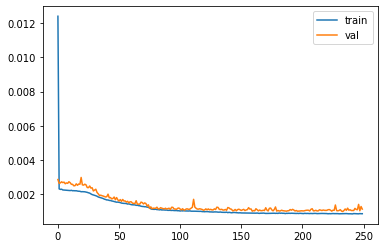

In [4]:
import matplotlib.pyplot as plt
caploss=np.array(caploss)
#plt.figsize((10,5))
plt.plot(caploss[:,0],caploss[:,1],label='train')
plt.plot(caploss[:,0],caploss[:,2],label='val')
plt.legend(('train','val'))
plt.savefig('loss.png')

In [4]:
import json
import trt_pose.coco
import numpy as np
import trt_pose.models
import torch
from torch2trt import torch2trt
from torch2trt import TRTModule
import cv2
import torchvision.transforms as transforms
from PIL import Image
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

pose =  {        'supercategory': 'forklift-person',
                 'id': 4,
                 'keypoints': ['top_front_left',
                               'top_front_right',
                               'top_back_left',
                               'top_back_right',
                               'bot_front_left',
                               'bot_front_right',
                               'bot_back_left',
                               'bot_back_right',
                               'nose',
                               'left_eye',
                               'right_eye',
                               'left_ear',
                               'right_ear',
                               'left_shoulder',
                               'right_shoulder',
                               'left_elbow',
                               'right_elbow',
                               'left_wrist',
                               'right_wrist',
                               'left_hip',
                               'right_hip',
                               'left_knee',
                               'right_knee',
                               'left_ankle',
                               'right_ankle'],
                 'name': 'forklift-person',
                 'skeleton': [[1, 2],
                              [1, 3],
                              [1, 5],
                              [2, 4],
                              [2, 6],
                              [3, 7],
                              [3, 4],
                              [4, 8],
                              [5, 6],
                              [5, 7],
                              [6, 8],
                              [7, 8],
                              [ 9, 10],
                              [ 9, 11],
                              [10, 11],
                              [10, 12],
                              [11, 13],
                              [12, 14],
                              [13, 15],
                              [14, 20],
                              [14, 15],
                              [14, 16],
                              [15, 21],
                              [15, 17],
                              [16, 18],
                              [17, 19],
                              [20, 22],
                              [20, 21],
                              [21, 23],
                              [22, 24],
                              [23, 25]]
                 }

topology = trt_pose.coco.coco_category_to_topology(pose)

In [2]:
class DrawObjects(object):
    
    def __init__(self, topology):
        self.topology = topology
        
    def __call__(self, image, object_counts, objects, normalized_peaks):
        topology = self.topology
        height = image.shape[0]
        width = image.shape[1]
        K = topology.shape[0]
        count = int(object_counts[0])
        print("count :", count)
        K = topology.shape[0]
        for i in range(count):
            color = (0, 255, 0)
            obj = objects[0][i]
            C = obj.shape[0]
            for j in range(C):
                k = int(obj[j])
                if k >= 0:
                    peak = normalized_peaks[0][j][k]
                    x = round(float(peak[1]) * width)
                    y = round(float(peak[0]) * height)
                    image=cv2.circle(image, (x, y), 3, color, 2)

            for k in range(K):
                c_a = topology[k][2]
                c_b = topology[k][3]
                if obj[c_a] >= 0 and obj[c_b] >= 0:
                    peak0 = normalized_peaks[0][c_a][obj[c_a]]
                    peak1 = normalized_peaks[0][c_b][obj[c_b]]
                    x0 = round(float(peak0[1]) * width)
                    y0 = round(float(peak0[0]) * height)
                    x1 = round(float(peak1[1]) * width)
                    y1 = round(float(peak1[0]) * height)
                    image=cv2.line(image, (x0, y0), (x1, y1), color, 2)
        return image


In [5]:
num_parts = len(pose['keypoints'])
num_links = len(pose['skeleton'])

model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()
MODEL_WEIGHTS = '../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_249.pth'
WIDTH = 224
HEIGHT = 224
data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()


model.load_state_dict(torch.load(MODEL_WEIGHTS))
model_trt = torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)
OPTIMIZED_MODEL = '../tasks/human_pose/experiments/resnet18_baseline_att_224x224_A.json.checkpoints/epoch_249_trt.pth'

torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)
model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')




In [6]:
parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

def execute(image):
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    test_data1=cmap.numpy()[0]
    test_data2=paf.numpy()[0]
    im=np.zeros((224,224))
    im1=np.zeros((224,224))

    for j in test_data1:
        j=cv2.resize(j,(224,224))*255
        im=np.maximum(im,j)

    for j in test_data2:
        j=cv2.resize(j,(224,224))*255
        im1=np.maximum(im1,j)
    im=cv2.merge([im,im,im])
    im1=cv2.merge([im1,im1,im1])
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    #image=cv2.UMat.get(image)
    #image=cv2.resize(image,(512,512))
    return image,im,im1

In [11]:
import matplotlib.pyplot as plt

image=cv2.imread('Img_120422_OHLF_1363.jpg')
image=cv2.resize(image, (224,224))
image,im,im1=execute(image)
im=cv2.resize(im,(512,512))
im1=cv2.resize(im1,(512,512))
cv2.imwrite('img3.jpg',im)
cv2.imwrite('img5.jpg',im1)

True

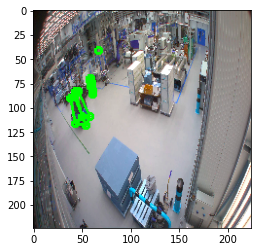

In [12]:
plt.imshow(image)

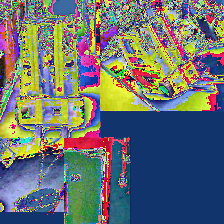

AttributeError: shape

In [50]:
parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)

image,cmap,paf,_ = test_dataset[50]
cmap=cmap.view((1,25,56,56))*255
paf=paf.view((1,62,56,56))*255
image=np.transpose(image.numpy(),(1,2,0))*255
image=Image.fromarray(np.uint8(image))
display(image)
#cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)

height = image.shape[0]
width = image.shape[1]
K = topology.shape[0]
count = int(counts[0])
K = topology.shape[0]
for i in range(count):
    color = (0, 255, 0)
    obj = objects[0][i]
    C = obj.shape[0]
    for j in range(C):
        k = int(obj[j])
        if k >= 0:
            peak = peaks[0][j][k]
            x = round(float(peak[1]) * width)
            y = round(float(peak[0]) * height)
            image=cv2.circle(image, (x, y), 1, color, 2)
    for k in range(K):
        c_a = topology[k][2]
        c_b = topology[k][3]
        if obj[c_a] >= 0 and obj[c_b] >= 0:
            peak0 = peaks[0][c_a][obj[c_a]]
            peak1 = peaks[0][c_b][obj[c_b]]
            x0 = round(float(peak0[1]) * width)
            y0 = round(float(peak0[0]) * height)
            x1 = round(float(peak1[1]) * width)
            y1 = round(float(peak1[0]) * height)
            image=cv2.line(image, (x0, y0), (x1, y1), color, 2)

image=cv2.UMat.get(image)

image=cv2.resize(image,(512,512))
image=Image.fromarray(np.uint8(image))
display(image)

In [ ]:
for i in range(0,10):
  im,cmap,paf,_ = train_dataset[i]
  test_data=im.numpy()
  test_data=np.transpose(test_data,axes=(1,2,0))*255
  test_data1=cmap.numpy()
  test_data2=paf.numpy()
  im=np.zeros((224,224))
  im1=np.zeros((224,224))

  for j in test_data1:
    j=cv2.resize(j,(224,224))*255
    im=np.maximum(im,j)

  for j in test_data2:
    j=cv2.resize(j,(224,224))*255
    im1=np.maximum(im1,j)

  im=cv2.merge([im,im,im])
  im1=cv2.merge([im1,im1,im1])
  im=0.9*im+0.1*(test_data)
  im=cv2.resize(im,(512,512))
  cv2_imshow(im)
  im1=0.5*im1+0.5*(test_data)
  im1=cv2.resize(im1,(512,512))
  cv2_imshow(im1)